# Instrumental Variables (IV) 
P.G.White

In [85]:
# ==============================
# Generate Synthetic Data
# ==============================
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from dowhy import CausalModel

np.random.seed(42)
n = 1000

# Instruments and common control
Z_d = np.random.normal(0, 1, n)          # Weather pattern (IV for demand)
Z_s = np.random.normal(0, 1, n)          # Price of substitute (IV for supply)
W = np.random.normal(0, 1, n)            # Common factor

# Stage 1: Generate log price as function of instruments
pi_0, pi_1, pi_2, pi_3 = 6.0, 6.0, 1.0, 0.8  # Stronger instrument effect
log_P = pi_0 + pi_1 * Z_d + pi_2 * Z_s + pi_3 * W + np.random.normal(0, 0.2, n)

# Demand-side parameters
b1 = -1.2  # true demand elasticity
a1, a2, a3 = 2.0, 0.5, 0.3
eps_d = np.random.normal(0, 0.1, n)
log_Qd = a1 + b1 * log_P + a2 * Z_d + a3 * W + eps_d

# Supply-side parameters
b2 = 0.8  # true supply elasticity
h1, h2, h3 = 1.0, 0.4, 0.2
eps_s = np.random.normal(0, 0.1, n)
log_Qs = h1 + b2 * log_P + h2 * Z_s + h3 * W + eps_s

# Combine into DataFrame
df = pd.DataFrame({
    'P': log_P,      # log price
    'Q_d': log_Qd,   # log quantity demanded
    'Q_s': log_Qs,   # log quantity supplied
    'Z_d': Z_d,
    'Z_s': Z_s,
    'W': W
})

print("Synthetic Data Sample:")
print(df.head())

Synthetic Data Sample:
           P        Q_d        Q_s       Z_d       Z_s         W
0   9.457936  -9.390069   8.948680  0.496714  1.399355 -0.675178
1   5.807356  -5.084435   5.941493 -0.138264  0.924634 -0.144519
2   9.229105  -8.987005   8.069087  0.647689  0.059630 -0.792420
3  14.622411 -14.830503  12.344552  1.523030 -0.646937 -0.307962
4   3.889722  -3.489513   4.085627 -0.234153  0.698223 -1.893615


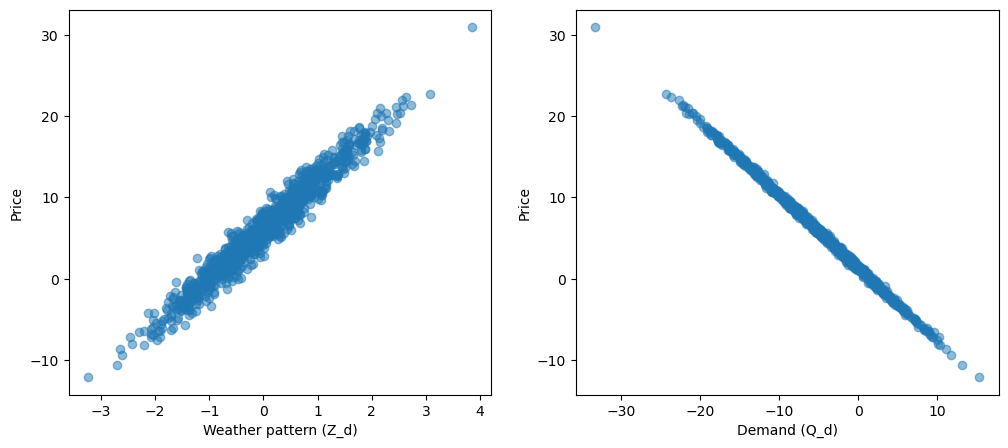

In [86]:
# ==============================
# Scatter plots
# ==============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(df['Z_d'], df['P'], alpha=0.5)
plt.xlabel('Weather pattern (Z_d)')
plt.ylabel('Price')
plt.subplot(1,2,2)
plt.scatter(df['Q_d'], df['P'], alpha=0.5)
plt.ylabel('Price')
plt.xlabel('Demand (Q_d)')
plt.show()

In [87]:
# ==============================
# Manual 2SLS for Demand and Supply
# ==============================
# Stage 1: Predict Price using instruments
Z = df[['Z_d', 'Z_s', 'W']]
stage1 = LinearRegression()
stage1.fit(Z, df['P'])
P_hat = stage1.predict(Z)
df['P_hat'] = P_hat

# Stage 2: Demand equation: Q_d ~ P_hat + Z_d + W
X_demand = np.column_stack([P_hat, df['Z_d'], df['W']])
y_demand = df['Q_d']
stage2_demand = LinearRegression()
stage2_demand.fit(X_demand, y_demand)

manual_b1 = stage2_demand.coef_[0]

# Stage 2: Supply equation: Q_s ~ P_hat + Z_s + W
X_supply = np.column_stack([P_hat, df['Z_s'], df['W']])
y_supply = df['Q_s']
stage2_supply = LinearRegression()
stage2_supply.fit(X_supply, y_supply)

manual_b2 = stage2_supply.coef_[0]

print("\nManual 2SLS Results:")
print(f"Demand Elasticity (b1): {manual_b1:.4f} | Ground Truth: -1.2")
print(f"Supply Elasticity (b2): {manual_b2:.4f} | Ground Truth: 0.8")



Manual 2SLS Results:
Demand Elasticity (b1): -1.2020 | Ground Truth: -1.2
Supply Elasticity (b2): 0.7999 | Ground Truth: 0.8


In [88]:
# ==============================
# DoWhy IV Estimation
# ==============================
# Demand IV estimation
model_demand = CausalModel(
    data=df,
    treatment='P',
    outcome='Q_d',
    common_causes=['W'],
    instruments=['Z_d', 'Z_s']
)
identified_estimand_demand = model_demand.identify_effect(proceed_when_unidentifiable=True)
estimate_demand = model_demand.estimate_effect(
    identified_estimand_demand,
    method_name="iv.instrumental_variable",
    method_params={"iv_instrument_name": ['Z_d', 'Z_s']}
)

# Supply IV estimation
model_supply = CausalModel(
    data=df,
    treatment='P',
    outcome='Q_s',
    common_causes=['W'],
    instruments=['Z_d', 'Z_s']
)
identified_estimand_supply = model_supply.identify_effect(proceed_when_unidentifiable=True)
estimate_supply = model_supply.estimate_effect(
    identified_estimand_supply,
    method_name="iv.instrumental_variable",
    method_params={"iv_instrument_name": ['Z_d', 'Z_s']}
)

print("\nDoWhy IV Results:")
print(f"Demand Elasticity (b1): {estimate_demand.value:.4f} | Ground Truth: -1.2")
print(f"Supply Elasticity (b2): {estimate_supply.value:.4f} | Ground Truth: 0.8")


DoWhy IV Results:
Demand Elasticity (b1): -1.1103 | Ground Truth: -1.2
Supply Elasticity (b2): 0.8189 | Ground Truth: 0.8


In [89]:
print("\nRobust Refutation Tests for Demand Elasticity:")
# Random Common Cause
print(model_demand.refute_estimate(identified_estimand_demand, estimate_demand,
                                   method_name="random_common_cause"))

# Bootstrap Refuter
print(model_demand.refute_estimate(identified_estimand_demand, estimate_demand,
                                   method_name="bootstrap_refuter",
                                   method_params={"num_simulations": 100}))

# Data Subset Refuter
print(model_demand.refute_estimate(identified_estimand_demand, estimate_demand,
                                   method_name="data_subset_refuter",
                                   method_params={"subset_fraction": 0.8}))


Robust Refutation Tests for Demand Elasticity:
Refute: Add a random common cause
Estimated effect:-1.1103358172579658
New effect:-1.1103358172579654
p value:1.0

Refute: Bootstrap Sample Dataset
Estimated effect:-1.1103358172579658
New effect:-1.108981568385036
p value:0.8600000000000001

Refute: Use a subset of data
Estimated effect:-1.1103358172579658
New effect:-1.1096486254103006
p value:0.8



### Refuters
*   **Random Common Cause**: If the estimate barely changes (p-value ≈ 1), the model is robust to adding random noise.
*   **Bootstrap**: If bootstrap confidence intervals are tight, the estimate is stable.
*   **Data Subset**: If effect remains similar when using subsets, the estimate is not driven by outliers.